## 1. Catalog of candidate properties

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [31]:
# We provide a dictionary containing the properties of candidates (both above and below threshold)
# from our search.

# Please download the PE samples from https://drive.google.com/drive/folders/1YkuIo-yIJhIOSX3B0zRGlSJzwIT5D61U?usp=sharing
# and rename the path below
samples_dir = Path('/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples')

# Note that the tgps entries correspond to the time at which the 22-phase is "linear-free" (see sec. 2B of 1904.01683)
# (rather than peak of the waveform convention as used by LVK)
# The difference in the two time conventions is minor though, i.e., less than 0.1s for most sources

import json
cands_dict = json.load(open(samples_dir/'IAS_HM_O3_triggers.json', 'r'))

In [32]:
# Keys in the event dictionary file
print(cands_dict['GW191228_195619'].keys())
# snr2_HL_modes has entries: [[22_H, 22_L], [33_H, 33_L], [44_H, 44_L]]

# The properties of the candidate with the given name can be accessed as follows
cands_dict['GW191228_195619']

dict_keys(['tgps', 'pastro', 'ifar_global', 'ifar_bank', 'snr2_H1', 'snr2_L1', 'snr2_HL_modes', 'bank_id', 'lvc_found', 'lvc_pastro', 'ogc_found', 'ogc_pastro', 'best_template_params', 'PE_summary'])


{'tgps': 1261598197.1296387,
 'pastro': 0.6707330261573474,
 'ifar_global': 0.120420370654101,
 'ifar_bank': 3.9962794520547944,
 'snr2_H1': 20.332398870172902,
 'snr2_L1': 89.4503984469477,
 'snr2_HL_modes': [[17.262987654001797, 81.67733618250989],
  [2.47685612032996, 5.6020147224552215],
  [0.5925550958411411, 2.171047541982604]],
 'bank_id': [14, 0],
 'lvc_found': False,
 'lvc_pastro': None,
 'ogc_found': False,
 'ogc_pastro': None,
 'best_template_params': {'m1': 187.64070952760372,
  'm2': 130.13337416428212,
  's1z': -0.4022795141429013,
  's2z': -0.39263385821572633,
  'l1': 0.0,
  'l2': 0.0,
  'mchirp': 135.58316234688363,
  'eta': 0.24181253327411387,
  'chieff': -0.3983294697048909,
  'chia': -0.07675026357746888,
  'ltil1': 0.0,
  'ltil2': 0.0},
 'PE_summary': {'m1': '$400_{-130}^{+140}$',
  'm2': '$120_{-60}^{+60}$',
  'm1_source': '$300_{-120}^{+60}$',
  'm2_source': '$90_{-40}^{+40}$',
  'q': '$0.29_{-0.15}^{+0.24}$',
  'chieff': '$-0.2_{-0.5}^{+0.7}$',
  'z': '$0.38_{-

In [33]:
# List of new events from HM search in arXiv:2312.06631 Table 1

New_IAS_events = [(0, 'GW190605_025957'),
                (1, 'GW190806_033721'),
                (2, 'GW190524_134109'),
                (3, 'GW191113_103541'),
                (4, 'GW190615_030234'),
                (5, 'GW190604_103812'),
                (6, 'GW191228_195619'),
                (7, 'GW200304_172806'),
                (8, 'GW190530_030659'),
                (9, 'GW190511_163209'),
                (10, 'GW200210_100022'),
                (11, 'GW200301_211019'),
                (12, 'GW190911_195101'),
                (13, 'GW190530_133833')]

In [34]:
print('Number, Name, GpsTime, IFAR, Pastro, bank, mchirp, snr2_H+snr2_L')
for i, ev in enumerate(New_IAS_events):
    ev = ev[1]
    cand = cands_dict[ev]
    print(i, ev, cand['tgps'],cand['ifar_global'], cand['pastro'],
          cand['best_template_params']['mchirp'], cand['snr2_H1']+cand['snr2_L1'])

Number, Name, GpsTime, IFAR, Pastro, bank, mchirp, snr2_H+snr2_L
0 GW190605_025957 1243738815.4174805 0.5860967889083947 0.8773680827267929 89.30321348139763 89.46214163931302
1 GW190806_033721 1249097859.923584 0.4587850851565712 0.8565320138862275 69.65541425398281 69.53753211702556
2 GW190524_134109 1242740487.3374023 0.4255105624968638 0.8500532729281325 41.02020616091494 67.63814779139643
3 GW191113_103541 1257676559.5012207 0.20535680958957434 0.7592884871508783 42.569974775496874 75.50657719015958
4 GW190615_030234 1244602972.855957 0.19503758153398895 0.7508993819184031 32.95051883823367 74.56294731455574
5 GW190604_103812 1243679910.9370117 0.12776549005900112 0.6826034396203433 55.051717879516985 67.69077515618122
6 GW191228_195619 1261598197.1296387 0.120420370654101 0.6707330261573474 135.58316234688363 109.78279731712061
7 GW200304_172806 1267378104.2041016 0.11419083199905118 0.6597325913691874 62.32980192785248 68.93818137179237
8 GW190530_030659 1243220837.9516602 0.095

In [35]:
# Full O3a+O3b catalog with pastro > 0.5
# Note that we have not included Virgo in our search as of now (all events are H+L)
print('# Number, Name, GPSTime, IFAR, Pastro, Bank, SNR_H, SNR_L')
for i, ev in enumerate([ev for ev in cands_dict if cands_dict[ev]['pastro']>0.5]):
    cand = cands_dict[ev]
    print(i, ev, cand['tgps'], np.round(cand['ifar_global'],3), np.round(cand['pastro'],2),
         cand['bank_id'], np.round(np.sqrt(cand['snr2_H1']),3), np.round(np.sqrt(cand['snr2_L1']),3))

# Number, Name, GPSTime, IFAR, Pastro, Bank, SNR_H, SNR_L
0 GW190530_030659 1243220837.9516602 0.095 0.63 [4, 2] 5.876 6.0
1 GW190711_030756 1246849694.628418 38.721 0.99 [7, 1] 5.703 8.299
2 GW190707_083226 1246523564.9475098 0.296 0.81 [7, 1] 7.028 6.344
3 GW190906_054335 1251783833.5065918 0.064 0.55 [7, 1] 5.225 6.607
4 GW190806_033721 1249097859.923584 0.459 0.86 [8, 1] 5.979 5.812
5 GW190818_232544 1250205962.3293457 0.225 0.77 [8, 1] 6.921 5.986
6 GW190511_163209 1241627547.6362305 0.085 0.61 [8, 0] 6.9 6.477
7 GW190524_134109 1242740487.3374023 0.426 0.85 [10, 0] 4.824 6.661
8 GW190615_030234 1244602972.855957 0.195 0.75 [10, 0] 4.908 7.104
9 GW190604_103812 1243679910.9370117 0.128 0.68 [12, 0] 5.44 6.172
10 GW190911_195101 1252266679.5856934 0.061 0.54 [12, 0] 5.034 7.442
11 GW190530_133833 1243258731.668213 0.058 0.53 [12, 0] 6.182 5.634
12 GW190605_025957 1243738815.4174805 0.586 0.88 [13, 0] 6.555 6.819
13 GW190707_093326 1246527224.1262207 inf 1.0 [0, 3] 7.847 10.746
14 G

In [38]:
print('LVK events found in our search')
print([ev for ev in cands_dict if cands_dict[ev]['lvc_found']==True])

print('Events in our search overlapping with 4-OGC')
print([ev for ev in cands_dict if cands_dict[ev]['ogc_found']==True])

LVK events found in our search
['GW190707_093326', 'GW190728_064510', 'GW190924_021846', 'GW190720_000836', 'GW190512_180714', 'GW190408_181802', 'GW190517_055101', 'GW190412_053044', 'GW190513_205428', 'GW190828_063405', 'GW190915_235702', 'GW190503_185404', 'GW190521_074359', 'GW190727_060333', 'GW190413_052954', 'GW190926_050336', 'GW190527_092055', 'GW190803_022701', 'GW190731_140936', 'GW190805_211137', 'GW190519_153544', 'GW190413_134308', 'GW190421_213856', 'GW190909_114149', 'GW190514_065416', 'GW190706_222641', 'GW190719_215514', 'GW190916_200658', 'GW190602_175927', 'GW190929_012149', 'GW190403_051519', 'GW191204_171526', 'GW191105_143521', 'GW191103_012549', 'GW191126_115259', 'GW191129_134029', 'GW200316_215756', 'GW200225_060421', 'GW200202_154313', 'GW191215_223052', 'GW191204_110529', 'GW200311_115853', 'GW200209_085452', 'GW200306_093714', 'GW200224_222234', 'GW200208_130117', 'GW200128_022011', 'GW200219_094415', 'GW200220_124850', 'GW200322_091133', 'GW191222_033537',

# 2. PE samples of new candidate events

In [7]:
import pickle
import pandas as pd

In [8]:
# We use cogwheel for plotting PE samples (https://github.com/jroulet/cogwheel)
import sys
sys.path.append('/data/jayw/IAS/GW/cogwheel') # Download cogwheel and change path here
from cogwheel.cosmology import z_of_d_luminosity
from cogwheel import posterior, data, likelihood, gw_plotting, utils

/data/jayw/IAS/GW/cogwheel/cogwheel/waveform.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [9]:
# Please download the PE samples from https://drive.google.com/drive/folders/1YkuIo-yIJhIOSX3B0zRGlSJzwIT5D61U?usp=sharing
# and rename the path below
samples_dir = Path('/data/jayw/IAS/GW/Data/HM_O3a_search/PE_samples')

In [10]:
eventname = New_IAS_events[6][1]

In [11]:
def transform_samples(s, lnl_cutoff=25):
    s['chieff'] = (s['m1']*s['s1z']+s['m2']*s['s2z'])/(s['m1']+s['m2'])
    s['lnq'] = -np.abs(s['lnq'] )
    s['z'] = z_of_d_luminosity(s['d_luminosity'])
    s['m1_source'] = s['m1']/(1+ s['z'])
    s['m2_source'] = s['m2']/(1+ s['z'])
    s['mtot'] = (s['m1']+s['m2'])
    s['q'] = np.exp(s['lnq'])
    s['s1_perp'] = np.sqrt(s['s1x_n']**2 + s['s1y_n']**2)
    s = s[s.lnl > (s.lnl.max() - lnl_cutoff)]
    s = s[s.lnl > 2]
    return(s)

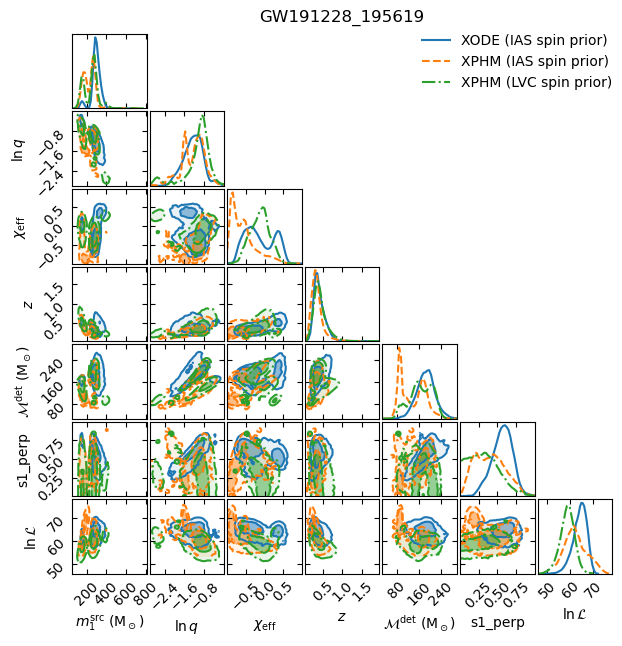

In [12]:
s0 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXODE_P_HM/samples.feather'))
s1 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXPHM_P_HM/samples.feather'))
s2 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicLVCPrior_IMRPhenomXPHM_P_HM/samples.feather'))

# Note that the samples using NAUTILUS come with weights and these are implicitly being
# passed to the plotter
mcp = gw_plotting.MultiCornerPlot((s0, s1, s2),
                    bins=40, labels=['XODE (IAS spin prior)', 'XPHM (IAS spin prior)', 'XPHM (LVC spin prior)'],
                       params=['m1_source', 'lnq', 'chieff', 'z','mchirp','s1_perp', 'lnl'], density=True)

mcp.plot(max_figsize=7, title=eventname)

In [13]:
# List of previously detected IAS events in Table 2

Prev_IAS_events = [(0, 'GW190711_030756'),
                 (1, 'GW190707_083226'),
                 (2, 'GW200109_195634'),
                 (3, 'GW190818_232544'),
                 (4, 'GW190906_054335')]

In [14]:
eventname = Prev_IAS_events[0][1]

In [15]:
s0 = transform_samples(pd.read_feather(samples_dir/f'{eventname}/IntrinsicIASPrior_IMRPhenomXODE_P_HM/samples.feather'))
max_lnl = dict(s0.iloc[np.argmax(s0['lnl'])])

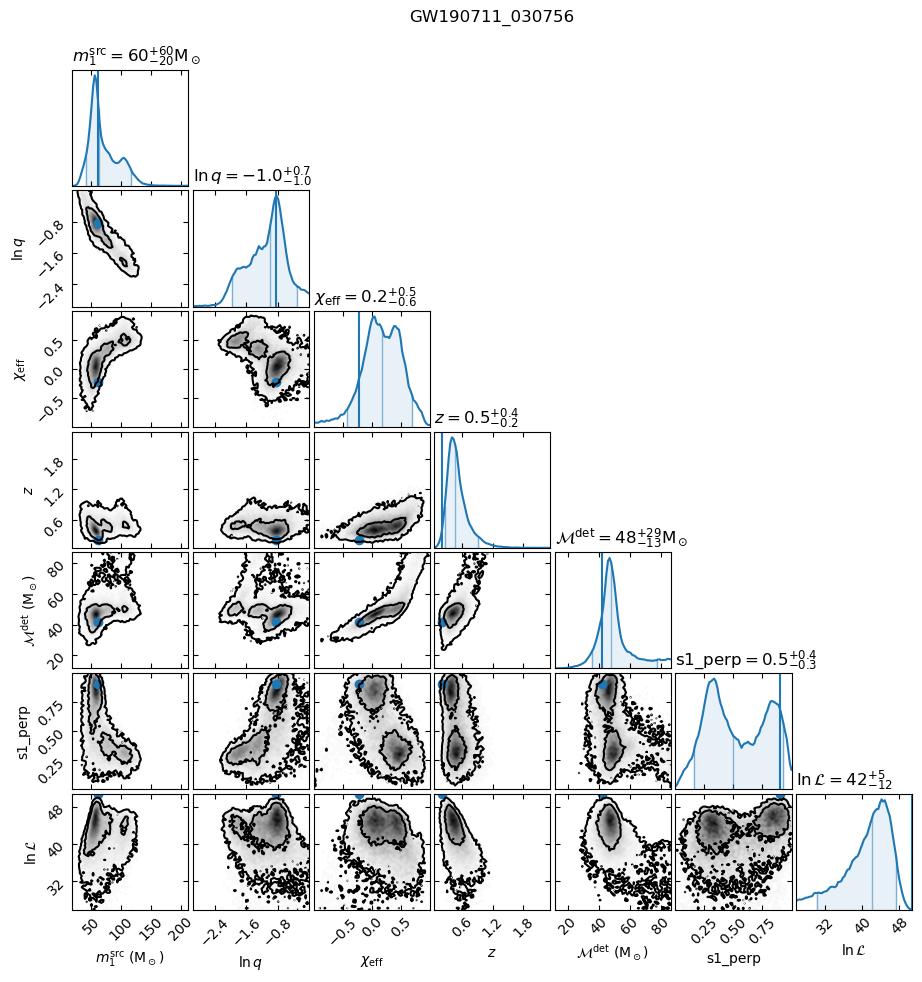

In [16]:
cp = gw_plotting.CornerPlot(s0[['m1_source', 'lnq', 'chieff', 'z','mchirp','s1_perp', 'lnl']])
cp.plot()
cp.scatter_points(max_lnl)
cp.fig.suptitle(eventname);

In [15]:
# We provide the .npz objects which can be used for running cogwheel PE for different priors
# at samples_dir/f'{eventname}/*.npz
# see https://github.com/jroulet/cogwheel/tree/main/tutorials for running cogwheel

# 3. PE samples of all events (including LVK, OGC and 22-only IAS events)

In [17]:
# All_Event_samples_IAS_spin_prior.pkl and All_Event_samples_LVC_spin_prior.pkl contain the PE samples for all events
# Please download the them from https://drive.google.com/drive/folders/1YkuIo-yIJhIOSX3B0zRGlSJzwIT5D61U?usp=sharing
# and rename the path below
with open(samples_dir/'All_Event_samples_IAS_spin_prior.pkl', 'rb') as f:
    all_evn_samples = pickle.load(f)

In [18]:
lnl_diff_allow = 25
# This is the maximum allowed difference in log-likelihood between the maximum and the rest of the samples
# This is introduced to make the plot look cleaner, otherwise tails of the distributions can be very long

for evn_name in all_evn_samples:
    if evn_name not in ['GW200305_084739','GW200210_005122']:
        evn = all_evn_samples[evn_name]
        mask = evn['lnl'] > (evn['lnl'].max() - lnl_diff_allow)
        for key in evn:
            if evn[key] is not None:
                evn[key] = evn[key][mask]
        all_evn_samples[evn_name] = evn

In [19]:
import os, sys, scipy
import matplotlib as mpl

sys.path.insert(0, str(samples_dir))
import grid as gd
# grid.py is given in the github repo, add the path to it using sys.path.insert

tab20 = list(mpl.cm.get_cmap('tab20').colors)
tab20b = list(mpl.cm.get_cmap('tab20b').colors)
COLORS = tab20[ : : 2] + tab20[1 : : 2] + tab20b  # 40 colors

c = np.array(
    [[240,0,0],
     [239,133,0],
     [223,204,0],
     [153,194,0],
     [0,109,0]]) / 255

r, g, b = [scipy.interpolate.interp1d(np.linspace(0, 1, len(c)), y, kind='cubic')
           (np.linspace(0, 1, 255)) for y in c.T]

cm = mpl.colors.ListedColormap(np.vstack([r, g, b]).T)
cm.set_under(color=mpl.colors.to_hex(COLORS[7]), alpha=0.15)
cm.set_over(color=mpl.colors.to_hex(COLORS[0]), alpha=0.9)
new_evnames_HM = [ev[1] for ev in New_IAS_events]

# This function calculates an expanded range for a given list of values
# It a list of values 'x' and an expansion factor 'e' (default value is 1.05)
def expanded_range(x, e=1.05):
    a = min(x)
    b = max(x)
    c = (a + b) / 2
    d = b - a
    return c - d/2*e, c + d/2*e

/tmp/ipykernel_1123052/3567377069.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = list(mpl.cm.get_cmap('tab20').colors)
/tmp/ipykernel_1123052/3567377069.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20b = list(mpl.cm.get_cmap('tab20b').colors)


In [20]:
def make_multievent_plot(plot_2d_params=['mtot_source', 'chieff'], ranges_2d=None,
                         figsize=(8,4), evnames=None, xlim=None, ylim=None, fill=False, fractions=[1-np.exp(-.5)],
                         zoom=2, linewidths=1.6, sigma_gaussian_filter=0, pastro_colors=True,
                         set_legend=False, fig=None, ax=None,
                         colors=None, scatter_marker='o', scatter_marker_size=2, scatter_alpha=1):
    if evnames is None:
        evnames = list(all_evn_samples)
    if ranges_2d is None:
        ranges_2d = {ev: None for ev in evnames}
        
    grids = {ev: gd.Grid.from_samples(plot_2d_params, all_evn_samples[ev], pdf_key=ev, range=ranges_2d[ev],
                                      bins=80, weights=all_evn_samples[ev]['weights'])
             for ev in evnames}
    for g in grids.values():
        g.change_resolution(zoom)
        g.gaussian_filter(sigma_gaussian_filter)
    if pastro_colors:
        colors=[]
        for ev in evnames:
            if ev in new_evnames_HM:
                pastro = cands_dict[ev]['pastro']
                colors.append(cm(pastro*2-1,alpha=0.7))
            else:
                colors.append(cm(-2001))

    mg = gd.MultiGrid([g for g in grids.values()],
                      colors=colors, fill=fill,
                      fractions=fractions, linestyles='-')   

    for ps in mg.plotstyles:
        ps.style_2d.linewidths = linewidths

    mg.plot_2d(*plot_2d_params, figsize=figsize, xlim=xlim, ylim=ylim, set_legend=set_legend,
               fig=fig, ax=ax)
    plt.grid(linestyle=':')
    
    if scatter_marker is not None:
        for evclr, ev in zip(colors, evnames):
            plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),
                        marker=scatter_marker, s=scatter_marker_size,
                        color=evclr, cmap=cm)# alpha=scatter_alpha,

/tmp/ipykernel_1123052/2048277093.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


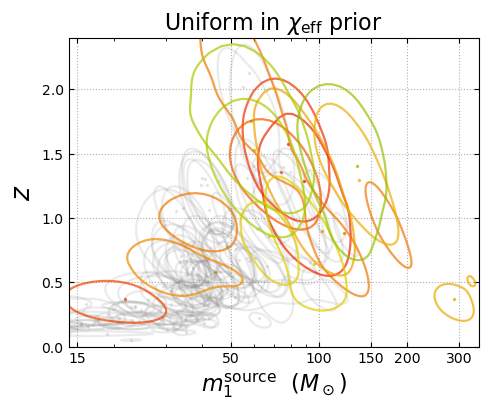

In [21]:
plot_2d_params = ['m1_source', 'z']
ranges_2d = {ev: [expanded_range(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(14, 350), ylim=(0,2.4), 
                     evnames=all_evn_samples.keys(),
                     sigma_gaussian_filter=4, fractions=[.5])

plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 150, 200, 300])
atest.set_xticklabels(['15', '50', '100', '150', '200', '300'])
atest.set_xlim(right=350)
atest.figure.set_figheight(4)
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$z$', fontsize=19);
atest.set_title('Uniform in $\chi_\mathrm{eff}$ prior', fontsize=16);

/tmp/ipykernel_1123052/2048277093.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


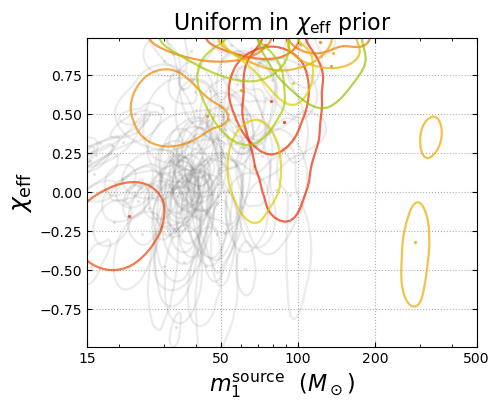

In [22]:
plot_2d_params = ['m1_source', 'chieff']
ranges_2d = {ev: [expanded_range(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(15, 350), ylim=(-0.99,0.99), 
                     evnames=all_evn_samples,
                     sigma_gaussian_filter=4, fractions=[.5])
plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 200, 500])
atest.set_xticklabels(['15', '50', '100', '200', '500'])
atest.set_yticks([-0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75])
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$\\chi_{{\\rm eff}}$', fontsize=18)
atest.figure.set_figheight(4)
atest.set_xlim(right=500); 
atest.set_title('Uniform in $\chi_\mathrm{eff}$ prior', fontsize=16);

/tmp/ipykernel_1123052/2048277093.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.median(all_evn_samples[ev][plot_2d_params[0]]), np.median(all_evn_samples[ev][plot_2d_params[1]]),


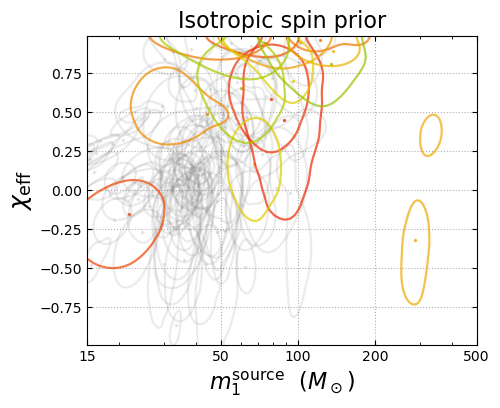

In [23]:
plot_2d_params = ['m1_source', 'chieff']
ranges_2d = {ev: [expanded_range(samples['m1_source']), None]
             for ev, samples in all_evn_samples.items()}

make_multievent_plot(plot_2d_params, ranges_2d, figsize=(5,3), xlim=(15, 350), ylim=(-0.99,0.99), 
                     evnames=all_evn_samples,
                     sigma_gaussian_filter=4, fractions=[.5])
plt.tight_layout()
atest = plt.gca()
atest.set_xscale('log')
atest.set_xticks([15, 50, 100, 200, 500])
atest.set_xticklabels(['15', '50', '100', '200', '500'])
atest.set_yticks([-0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75])
atest.set_xlabel(r'$m^\mathrm{source}_1\ \ (M_\odot)$', fontsize=16)
atest.set_ylabel('$\\chi_{{\\rm eff}}$', fontsize=18)
atest.figure.set_figheight(4)
atest.set_xlim(right=500); 
atest.set_title('Isotropic spin prior', fontsize=16);